In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import scqubits as scq
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep

import numpy as np

# Running Parameter Sweeps
Determining the dependence of physical observables on an external parameter is a common way to gain intuition about the characteristics or behavior of a system. Such parameter sweeps can be performed with scqubits on multiple levels: 

* at the level of a single qubit,
* at the level of a composite quantum system.

## Parameter sweeps for a single qubit
At the single-qubit level, each qubit class provides several methods that enable producing parameter sweep data and plots. Central quantities of interest, in this case, are energy eigenvalues and matrix elements -- in particular, their dependence on parameters like flux or offset charge.

The relevant methods available for every implemented qubit class are:

|  class method                               |   purpose                     |
|---------------------------------------------|-------------------------------|
| `<qubit>.get_spectrum_vs_paramvals(...)`    | for each provided value of a specified qubit parameter, compute eigenvalues and eigenvectors                                          |
| `<qubit>.get_matelements_vs_paramvals(...)` | for each provided value of a specified qubit parameter, compute matrix elements of a given operator w.r.t. the qubit eigenstates | 
| `<qubit>.plot_evals_vs_paramvals(...)`      | plot the energy eigenvalues as a function of a specified qubit parameter |
| `<qubit>.plot_matelem_vs_paramvals(...)`    | plot the matrix elements for a given operator as a function of a specified qubit parameter                                           |

The following code illustrates this functionality for the example of a fluxonium qubit.

In [3]:
fluxonium_qbt = scq.Fluxonium.create()

Output()

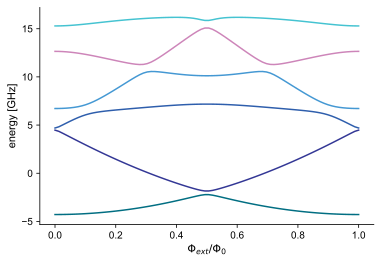

In [23]:
# define an array of flux values
fluxvals = np.linspace(0, 1, 80)
fluxonium_qbt.plot_evals_vs_paramvals(param_name='flux', param_vals=fluxvals);

Note: the argument `param_name` must be one of the parameters with which the qubit in question is initialized. (More flexibility can be achieved by using the `ParameterSweep` class below.)

To generate spectral data, and return them in the form of a `SpectrumData` object, we can instead use:

In [24]:
specdata = fluxonium_qbt.get_spectrum_vs_paramvals(param_name='flux', param_vals=fluxvals);
specdata

To retrieve eigenvalues and eigenvectors, one simply accesses the attributes `.energy_table` and `.state_table`. Furthermore, `SpectrumData` itself allows one to produce a plot of the eigenvalues from the generated data.

These are the lowest six eigenenergies (in GHz, by default) for the first flux value:

In [25]:
specdata.energy_table[0]

array([-4.28338463,  4.47506063,  4.69616798,  6.71864972, 12.64960539,
       15.28847499])

And this generates the eigenenergy plot:

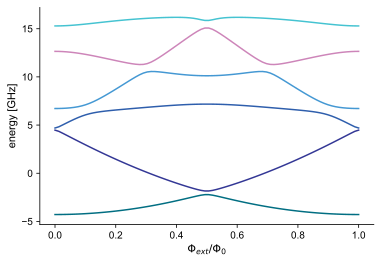

In [26]:
specdata.plot_evals_vs_paramvals();

In a similar manner, one can generate a plot of matrix elements as a function of a parameter value. (Since matrix elements are generally complex-valued, the absolute value is plotted by default. The `mode` argument allows for additional options.) 

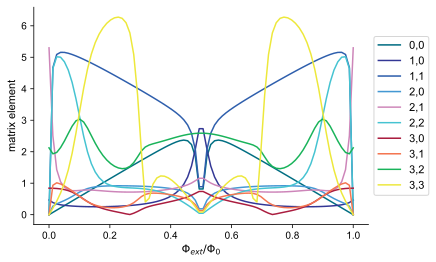

In [27]:
fluxonium_qbt.plot_matelem_vs_paramvals(operator='phi_operator', param_name='flux', param_vals=fluxvals);

## Parameter sweeps in composite Hilbert spaces
Composite Hilbert spaces, as defined by `HilbertSpace` objects, are more complicated than individual qubits, and a variety of parameter sweeps may be of interest. The parameter to be varied does not need to be a qubit parameter, but could be a coupling strength or other quantity. 

To enable such flexibility, scqubits provides the `ParameterSweep` class. In order to show its usage, we first define a composite Hilbert space - using the example of two tunable transmon qubits coupled to an oscillator. (See the `HilbertSpace` section in the user guide for details on this topic.) 

In [4]:
tmon1 = scq.TunableTransmon(
    EJmax=40.0,
    EC=0.2,
    d=0.1,
    flux=0.0,
    ng=0.3,
    ncut=40,
    truncated_dim=4     # after diagonalization, we will keep 3 levels
)

tmon2 = scq.TunableTransmon(
    EJmax=15.0,
    EC=0.15,
    d=0.2,
    flux=0.0,
    ng=0.0,
    ncut=30,
    truncated_dim=4
)

resonator = scq.Oscillator(
    E_osc=4.5,
    truncated_dim=4    # up to 3 photons (0,1,2,3)
)


g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

interaction1 = InteractionTerm(
    g_strength = g1,
    op1 = tmon1.n_operator(),
    subsys1 = tmon1,
    op2 = resonator.creation_operator() + resonator.annihilation_operator(),
    subsys2 =resonator
)

interaction2 = InteractionTerm(
    g_strength = g2,
    op1 = tmon2.n_operator(),
    subsys1 = tmon2,
    op2 = resonator.creation_operator() + resonator.annihilation_operator(),
    subsys2 = resonator
)

interaction_list = [interaction1, interaction2]

hilbertspace = scq.HilbertSpace([tmon1, tmon2, resonator], interaction_list=interaction_list)

The `ParameterSweep` class facilitates computation of spectra as function of an external parameter. For efficiency in computing a variety of quantities, and creating different kinds of plots, the computed bare and dressed spectral data are stored internally. 

A `ParameterSweep` object is initialized by providing the following parameters:

1. `param_name`: the name of the sweep parameter; this is purely informative and does not need to correspond to a qubit class attribute
2. `param_vals`: an array of parameter values used for the sweep
3. `subsys_update_list`: a list containing those Hilbert space subsystems that change as the parameter of interest is varied
4. `update_hilbertspace(param_val)`: a function that defines how a change in the sweep parameter affects the Hilbert space

These ingredients all enter as initialization arguments of the `ParameterSweep` object. Once initialized, spectral data is generated and stored.

In our example, the parameter to be changed will be a global magnetic field that affects the fluxes for both qubits, in proportions according to their SQUID loop areas. We will reference the flux for transmon 1, and use a flux for transmon 2 adjusted by an area ratio: 


In [10]:
param_name = 'tmon1 flux'         # name of varying external parameter
flux_vals = np.linspace(0.0, 2.0, 300)     # parameter values

area_ratio = 1.2

subsys_update_list = [tmon1, tmon2]          # list of HilbertSpace subsystems which are affected by parameter changes         

def update_hilbertspace(flux_val):          # function that defines how Hilbert space components are updated
    tmon1.flux = flux_val
    tmon2.flux = area_ratio * flux_val
    
    
sweep = ParameterSweep(
    param_name=param_name,
    param_vals=flux_vals,
    evals_count=20,
    hilbertspace=hilbertspace,
    subsys_update_list=subsys_update_list,
    update_hilbertspace=update_hilbertspace,
)

Once the data has been generated, the spectrum can be plotted as a function of the parameter value. For this, we use a function from the `sweep_plotting` module. Its functions take a `ParameterSweep` object as input. To plot the dressed spectrum vs the chosen parameter, we execute

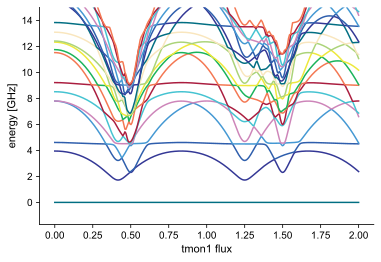

In [11]:
import scqubits.utils.sweep_plotting as splot

splot.dressed_spectrum(sweep);

The above plot shows the eigenenergies of the coupled system. Easily visible are the set of nearly horizontal lines (interrupted by various avoided crossings) with approximately equal spacing, corresponding to the excitation levels of the harmonic oscillator.  With careful inspection one can also identify the set of levels of each transmon, distinguished by their difference in flux-periodicity: `tmon1` with period "1" and `tmon2` with period "1.2".

The `sweep_plotting` module has several other functions for other plot varieties. For instance, we can select one of the subsystems and plot the bare spectrum (in the absence of interaction):

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x235eb7f8248>)

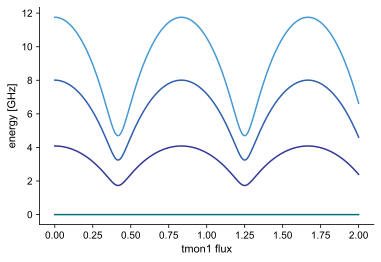

In [16]:
splot.bare_spectrum(sweep, subsys=tmon2, subtract_ground=True)



The `sweep_plotting` module has several other functions for other plot varieties:


|  plot function                  |  purpose                                            |
|---------------------------------|-----------------------------------------------------|
|  `dressed_spectrum(...)`        |  eigenenergies of the coupled system, see above     |
|  `bare_spectrum(...)`           |  bare energies of a selected subsystem, see above   |
|  `difference_spectrum(...)`     |  transition energies as seen when starting the system in a given initial state other than the ground state |
|  `n_photon_qubit_spectrum(...)` |  n-photon energies for transitions among qubit levels (meaningful in the dispersive regime) |

More details including the plot functions' arguments can be found in the [API documentation](../../api-doc/functions.rst).